<a href="https://colab.research.google.com/github/blankon123/random-analytics/blob/main/Time_Series_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series with LSTM
Dalam rangka mengerjakan projek mandiri Intermediate Machine Learning - Indosat Ooredoo Scholarship di dicoding. Data yang digunakan yakni data konsumsi listrik *PJM Interconnection LLC East Region* dari [Public Dataset](https://www.kaggle.com/robikscube/hourly-energy-consumption?select=PJME_hourly.csv). Data terdiri dari 145366 row dari tahun 2001-2018

In [202]:
#Memastikan menggunakan GPU dalam komputasinya
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [203]:
#Loading Library yang digunakan
import numpy as np 
import pandas as pd 
from keras.layers import Dense, LSTM 
import matplotlib.pyplot as plt 
import tensorflow as tf 

In [204]:
from google.colab import files
uploaded = files.upload()

Saving PJME_hourly.csv to PJME_hourly (2).csv


In [219]:
import io
df = pd.read_csv('/content/PJME_hourly.csv',parse_dates=[0])
df = df.sort_values('Datetime')
df = df.set_index('Datetime')
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [220]:
validation_set = 20
validation_cutoff = df.shape[0]*(100-validation_set)//100 
data_train = df.iloc[:validation_cutoff,]
data_test = df.iloc[validation_cutoff:,]

In [221]:
data_train.shape

(116292, 1)

In [222]:
data_train.isnull().sum()

PJME_MW    0
dtype: int64

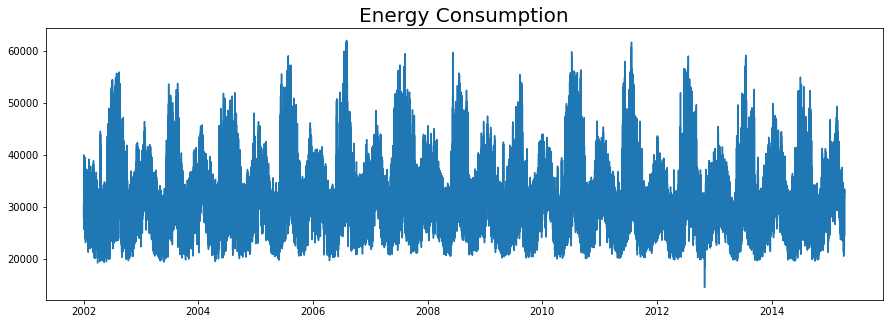

In [223]:
dates = data_train.index.values 
temp  = data_train['PJME_MW'].values 
temp_test = data_test['PJME_MW'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temp) 
plt.title('Energy Consumption',fontsize=20); 

In [224]:
#Perhitungan skala data
import sklearn.preprocessing
scaler = sklearn.preprocessing.MinMaxScaler()
temp = scaler.fit_transform(temp.reshape(-1,1))
temp = temp.reshape(1,-1)[0]

temp_test = scaler.transform(temp_test.reshape(-1,1)).reshape(1,-1)[0]

#Karena menggunakan MinMax Scaler, data ada di range 0-1, sehingga 10% nya yaitu 0.1
mae_range = (max(temp) - min(temp))*(10/100)
mae_range

0.1

In [225]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer): 
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series) 
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True) 
    ds = ds.flat_map(lambda w: w.batch(window_size + 1)) 
    ds = ds.shuffle(shuffle_buffer) 
    ds = ds.map(lambda w: (w[:-1], w[-1:])) 
    return ds.batch(batch_size).prefetch(1) 

In [226]:
tf.keras.backend.clear_session()

train_set = windowed_dataset(temp, window_size=24, batch_size=12000, shuffle_buffer=12000) 
test_set = windowed_dataset(temp_test, window_size=24, batch_size=12000, shuffle_buffer=12000)

model = tf.keras.models.Sequential([ 
  tf.keras.layers.LSTM(60, return_sequences=True), 
  tf.keras.layers.LSTM(60), 
  tf.keras.layers.Dense(30, activation="relu"), 
  tf.keras.layers.Dense(10, activation="relu"), 
  tf.keras.layers.Dense(1), 
]) 

In [227]:
#Karena proses training berjalan lama, diperlukan callback agar ketika goal tercapai (MAE<0.1) , epoch selanjutnya tidak diperlukan
class myCallback(tf.keras.callbacks.Callback): 
  def on_epoch_end(self, epoch, logs={}): 
    if(logs.get('val_mae')<mae_range and logs.get('mae')<mae_range): 
      print("\nMAE Range <",mae_range,"!") 
      self.model.stop_training = True 

callbacks = myCallback() 

In [228]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-02, momentum=0.9) 

model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer, 
              metrics=["mae"]) 

history = model.fit(train_set,
                    epochs=100,
                    callbacks=[callbacks],
                    validation_data=test_set,
                    verbose=2)

Epoch 1/100
10/10 - 63s - loss: 0.0494 - mae: 0.2757 - val_loss: 0.0119 - val_mae: 0.1143
Epoch 2/100
10/10 - 44s - loss: 0.0105 - mae: 0.1149 - val_loss: 0.0158 - val_mae: 0.1553
Epoch 3/100
10/10 - 44s - loss: 0.0117 - mae: 0.1267 - val_loss: 0.0095 - val_mae: 0.1150
Epoch 4/100
10/10 - 44s - loss: 0.0084 - mae: 0.0996 - val_loss: 0.0083 - val_mae: 0.0974

MAE Range < 0.1 !


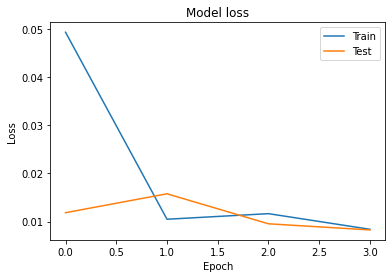

In [231]:
import matplotlib.pyplot as plt 

plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train','Test'], loc='upper right') 
plt.show() 

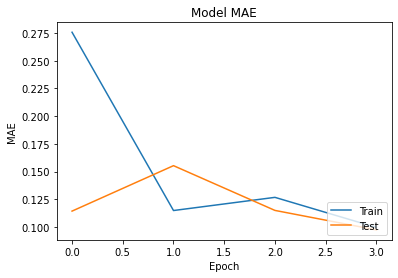

In [232]:
plt.plot(history.history['mae']) 
plt.plot(history.history['val_mae']) 
plt.title('Model MAE')
plt.ylabel('MAE') 
plt.xlabel('Epoch') 
plt.legend(['Train','Test'], loc='lower right') 
plt.show() 

Syarat Kelulusan ✅
- [x] Dataset yang akan dipakai bebas, namun minimal memiliki 1000 sampel.
- [x] Harus menggunakan LSTM dalam arsitektur model.
- [x] Harus menggunakan model sequential.
- [x] Validation set sebesar 20% dari total dataset.
- [x] MAE < 10% skala data.
- [x] Harus menggunakan Learning Rate pada Optimizer.

Syarat ⭐⭐⭐⭐⭐
- [x] Mengimplementasikan Callback.
- [x] Membuat plot loss dan akurasi pada saat training dan validation.
- [x] Dataset memiliki minimal 10000 sampel data
- [x] MAE dari model < 10% skala data (0.1).